In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()

В методе опорных векторов мы ищем прямую(в двумерном) и многообразие(в многомерном пространстве) отделяющие классы друг от друга. Смысл в том, чтобы найти прямую или многообразие с максимальным отступом.

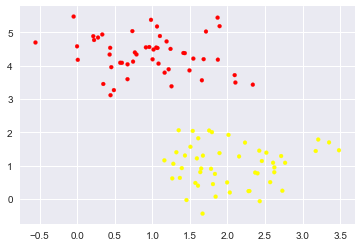

In [2]:
# Например у нас следующие следующие данные.
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=100, centers=2, cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=15, cmap='autumn');

In [3]:
# Взглянем на классификацию методом опорных векторов на этом наборе
# Пока будем использовать линейной ядро и большое значение параметра C

from sklearn.svm import SVC

model = SVC(kernel='linear', C=1e10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [4]:
# Для красивой визуализации нашей модели напишем функцию
def plot_svc_func(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Создание координатной сетки для оценки модели
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # Рисуем границы принятия решений
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    # Рисуем опорные векторы
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   s=150, linewidth=1, facecolors='none', edgecolors='k');
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

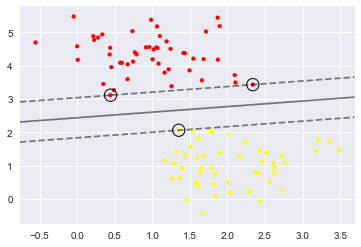

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=15, cmap='autumn')
plot_svc_func(model);

Эта раззделяющая линия максимизирует отступ между двумя наборами точек. Выделенные точки только касаются отступа и называются ***Опорными веторами***. Они хранятся в атрибуте модели **support_vectors_**

In [6]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [1.35139348, 2.06383637]])

In [7]:
# ключ к успеху классификатора - значение имеют только эти векторы. 
# Все значения которые находятся дольше не имеют влияния.

def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
    
    X = X[:N]
    y = y[:N]

    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_func(model, ax)
    

In [8]:
%matplotlib notebook
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

### SVM-ядро: Выход за пределы линейности

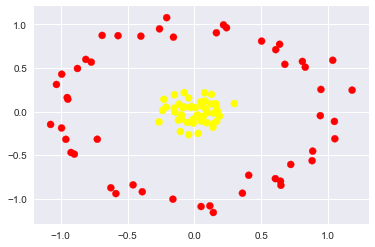

In [9]:
# Возможности метода SVM особенно расширяются при использовании ядер(kernel). 
# Например если у нас есть следующие данные:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)
%matplotlib inline
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [10]:
# Очевидно, что эти данные линейно не разделимы
# Но если использовать ядро на основании такой радиальной базисной функции, центрированной по середине совокупности данных:
r = np.exp(-(X ** 2).sum(1))

<IPython.core.display.Javascript object>


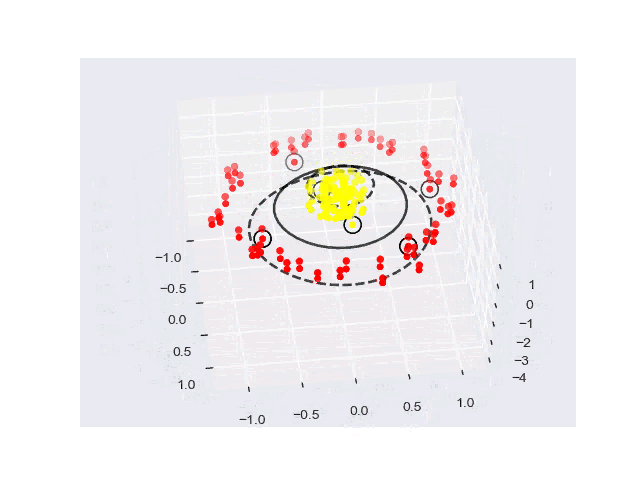

In [14]:
# Можно получить следующие результаты
%matplotlib notebook
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=25, cmap='autumn')
ax.view_init(elev=30, azim=30)

Тут уже намного проще найти разделяющую плоскость. Но нам пришлось тщательно выбрать и внимательно настроить нашу проекцию.
Если бы мы **не** центрировали должным образом нашу проекцию, то **не** получили бы чистых, разделяемых линейно результатов.

Чтобы автоматически находить оптимальную базисную функцию, стандартно используют преобрахование ядра(kernel transformation) вычисление базисной функции центрированных по каждой точке набора данных. Потенциальная проблема данной методики - проекция N точек на N измерений. Что может потребовать огромных затрат ресурсов для вычисления. Однако благодаря **kernel trick**, можно провести обучение без построения N-мерной проекции.

In [16]:
# В библиотеки SVM для исползования ядерного преобразования достаточно просто заменить ядро(kernel) с линейного на rbf.
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

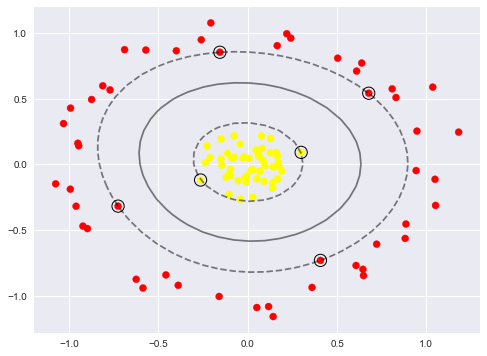

In [26]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_func(clf)

### Настройка SVM: Размытие отступов

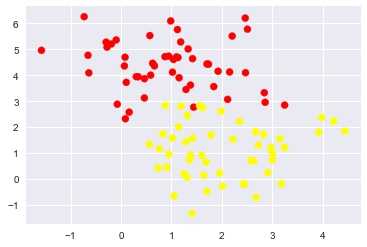

In [31]:
# Если данные перекрываются и граница между ними размыта.
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

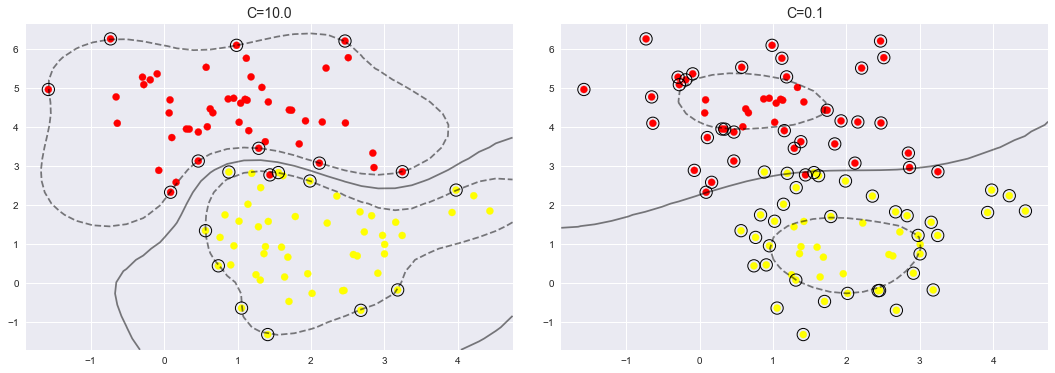

In [34]:
# На этот случай у SVM есть поправочный коэффициент C(Степень размытости).
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10, 0.1]):
    model = SVC(kernel='rbf', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_func(model, axi)
    axi.set_title('C={:.1f}'.format(C), size=14)

В учебнике неплохой пример с распознаванием лиц с помощью этого метода.